In [1]:
%matplotlib inline

### 训练一个分类器

上一讲中已经看到如何去定义一个神经网络，计算损失值和更新网络权重。


### 关于数据？

处理图像、文本、音频和视频数据时，可以使用标准Python包加载数据到numpy数组中，把数组转换成 ``torch.*Tensor``。

-  图像用 Pillow, OpenCV
-  音频用 scipy, librosa
-  文本用 原始Python和Cython加载，或者NLTK或SpaCy处理

对于图像任务，包``torchvision``包含处理一些基本图像数据集的方法。

数据集包括Imagenet, CIFAR10, MNIST 等。除了数据加载，``torchvision`` 还包含图像转换器，

``torchvision.datasets`` 和 ``torch.utils.data.DataLoader``。``torchvision``包提供巨大的便利，避免代码重复。

教程使用CIFAR10数据集，有10个类别：‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’。

CIFAR-10图像都是3x32x32大小，即3颜色通道，32x32像素。

![](https://pytorch.org/tutorials/_images/cifar10.png)


### 训练一个图像分类器

1. ``torchvision``加载和归一化CIFAR10训练集和测试集
2. 定义卷积神经网络
3. 定义损失函数
4. 训练集训练网络
5. 测试集测试网络

**1. 读取和归一化 CIFAR10**

``torchvision``可以非常容易地加载CIFAR10。

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision输出[0,1]的PILImage图像，转换为归一化范围为[-1, 1]的张量。

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=False,
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=False,
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=4,
                                         shuffle=False,
                                         num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
           'ship', 'truck')

frog plane truck ship


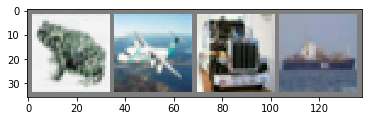

In [4]:
import matplotlib.pyplot as plt
import numpy as np




def imshow(img):
    # 展示图像
    # unnormalize
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# 获取随机数据
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 展示图像
imshow(torchvision.utils.make_grid(images))
# 显示图像标签
print(' '.join('%s' % classes[labels[j]] for j in range(4)))

**2. 定义卷积神经网络**
从神经网络一节复制神经网络代码，修改为输入3通道图像。

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

**3. 定义损失函数和优化器**

用交叉熵作为损失函数，用带动量的随机梯度下降。

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

**4. 训练网络**

有趣的时刻开始,只需在数据迭代器上循环，将数据输入给网络并优化。

In [7]:
len(trainloader)

12500

In [8]:
# 多批次循环
for epoch in range(3):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        # 获取输入
        inputs, labels = data

        # 梯度置0
        optimizer.zero_grad()

        # 正向传播，反向传播优化
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 打印状态信息
        running_loss += loss.item()
        if i % 4000 == 3999:  # 每4000批次打印一次
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 4000))
            running_loss = 0.0

print('Finished Training')

[1,  4000] loss: 2.035
[1,  8000] loss: 1.628
[1, 12000] loss: 1.477
[2,  4000] loss: 1.364
[2,  8000] loss: 1.317
[2, 12000] loss: 1.280
[3,  4000] loss: 1.212
[3,  8000] loss: 1.191
[3, 12000] loss: 1.173
Finished Training


**5. 在测试集上测试网络**

整个训练集进行3次训练，检查网络是否从数据集学习到有用的东西,将神经网络预测输出的标签与实际情况标签对比。

如果预测正确，把该样本添加到正确预测列表。
第一步，显示测试集中的图片并熟悉图片内容。

GroundTruth:  cat ship ship plane


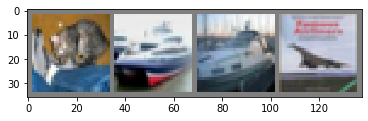

In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 显示图片
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%s' % classes[labels[j]] for j in range(4)))

看看神经网络认为以上图片是什么。

In [10]:
outputs = net(images)

输出是10个标签的能量。
类别能量越大，神经网络越认为它是这个类别，得到最高能量的标签。

In [11]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%s' % classes[predicted[j]] for j in range(4)))

Predicted:  cat ship ship plane


结果看来不错，接下来看看网络在整个测试集的结果如何。

In [12]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' %
      (100 * correct / total))

Accuracy of the network on the 10000 test images: 59 %


结果看起来不错，至少比随机选择要好，随机选择的正确率为10%。

在识别哪一个类的时候好，哪一个不好呢？

In [13]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' %
          (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 69 %
Accuracy of   car : 65 %
Accuracy of  bird : 44 %
Accuracy of   cat : 37 %
Accuracy of  deer : 49 %
Accuracy of   dog : 56 %
Accuracy of  frog : 61 %
Accuracy of horse : 69 %
Accuracy of  ship : 73 %
Accuracy of truck : 67 %


### 如何在GPU上运行神经网络

把一个神经网络移动到GPU上训练就像把一个Tensor转换到GPU上一样简单。

这个操作会递归遍历有所模块，将其参数和缓冲区转换为CUDA张量。

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 确认电脑支持CUDA，然后显示CUDA信息：
print(device)

cpu


本节其余部分假定`device`是CUDA设备。方法将递归遍历所有模块，并将模块的参数和缓冲区转换成CUDA张量：
```python

    net.to(device)
```

记住：inputs, targets 和 images也要转换。

```python

        inputs, labels = inputs.to(device), labels.to(device)
```
为什么没注意到GPU速度提升很多？因为网络非常小。

**实践:** 
增加网络宽度（第一个``nn.Conv2d``的第2个参数，第二个``nn.Conv2d``的第一个参数，需要是相同数字），看看得到什么样的加速。

**实现的目标**:

- 深入了解PyTorch的张量库和神经网络
- 训练一个小网络分类图片

后面教程会训练一个真正网络，使识别率达到90%以上。

### 多GPU训练

如果想使用所有GPU得到更大加速，请查看[数据并行处理](5_data_parallel_tutorial.ipynb)。

### 下一步？

-  :doc:`训练神经网络玩电子游戏 </intermediate/reinforcement_q_learning>`
-  `在ImageNet上训练最好的ResNet`
-  `使用对抗生成网络来训练一个人脸生成器`
-  `使用LSTM网络训练一个字符级的语言模型`
-  `更多示例`
-  `更多教程`
-  `在论坛上讨论PyTorch`
-  `Slack上与其他用户讨论`